# Training Logistic Regression via Stochastic Gradient Ascent

The goal of this notebook is to implement a logistic regression classifier using stochastic gradient ascent. You will:

 * Extract features from Amazon product reviews.
 * Convert a dataframe into a NumPy array.
 * Write a function to compute the derivative of log likelihood function with respect to a single coefficient.
 * Implement stochastic gradient ascent.
 * Compare convergence of stochastic gradient ascent with that of batch gradient ascent.

In [7]:
import numpy as np
import pandas as pd
import json
import string
import matplotlib.pyplot as plt
%matplotlib inline

## Load and process review dataset

In [3]:
products = pd.read_csv('data_files/amazon_baby_subset.csv')

Just like we did previously, we will work with a hand-curated list of important words extracted from the review data. We will also perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string manipulation functionality.
2. Compute word counts (only for the important_words)

In [5]:
with open('data_files/important_words.json') as important_words_file:    
    important_words = json.load(important_words_file)
print (important_words[:3])

['baby', 'one', 'great']


In [8]:
products = products.fillna({'review':''})  # fill in N/A's in the review column

def remove_punctuation(text):
    translator = str.maketrans('','',string.punctuation)
    return text.translate(translator)

products['review_clean'] = products['review'].apply(remove_punctuation)
products.head(3)

,name,review,rating,sentiment,review_clean
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...


In [9]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

### Split data into training and validation sets

We will now split the data into a 90-10 split where 90% is in the training set and 10% is in the validation set. We use `seed=1` so that everyone gets the same result.

In [12]:
with open('data_files/module-10-assignment-train-idx.json') as train_data_file:    
    train_data_idx = json.load(train_data_file)
with open('data_files/module-10-assignment-validation-idx.json') as validation_data_file:    
    validation_data_idx = json.load(validation_data_file)
    
train_data = products.iloc[train_data_idx]
valid_data = products.iloc[validation_data_idx]

## Convert DataFrame to NumPy array

Just like in the earlier assignments, we provide you with a function that extracts columns from an SFrame and converts them into a NumPy array. Two arrays are returned: one representing features and another representing class labels. 

**Note:** The feature matrix includes an additional column 'intercept' filled with 1's to take account of the intercept term.

In [13]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.to_numpy()
    label_sarray = dataframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

In [14]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(valid_data, important_words, 'sentiment')

<ipython-input-13-9cef56106022>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['constant'] = 1


In [15]:
print (feature_matrix_train.shape)
print (feature_matrix_valid.shape)

(47780, 194)
(5292, 194)


## Building on logistic regression

Let us now build on Module 3 assignment. Recall from lecture that the link function for logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 


We will use the **same code** as in Module 3 assignment to make probability predictions, since this part is not affected by using stochastic gradient ascent as a solver. Only the way in which the coefficients are learned is affected by using stochastic gradient ascent as a solver.

In [16]:
def predict_probability(feature_matrix, coefficients):
    score = np.dot(feature_matrix, coefficients)  # feature_matrix:N*D, coefficients: D*1
    predictions = 1.0/(1+np.exp(-score))
    return predictions

## Derivative of log likelihood with respect to a single coefficient

Let us now work on making minor changes to how the derivative computation is performed for logistic regression.

Recall from the lectures and Module 3 assignment that for logistic regression, **the derivative of log likelihood with respect to a single coefficient** is as follows:

$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

In Module 3 assignment, we wrote a function to compute the derivative of log likelihood with respect to a single coefficient $w_j$. The function accepts the following two parameters:
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$

In [17]:
'''
errors: N * 1
feature: N * 1
derivative: 1 
'''

def feature_derivative(errors, feature):     
    derivative = np.dot(errors, feature)
    return derivative

To verify the correctness of the gradient computation, we provide a function for computing average log likelihood (which we recall from the last assignment was a topic detailed in an advanced optional video, and used here for its numerical stability).

To track the performance of stochastic gradient ascent, we provide a function for computing **average log likelihood**. 

$$\ell\ell_A(\mathbf{w}) = \color{red}{\frac{1}{N}} \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) $$

**Note** that we made one tiny modification to the log likelihood function (called **compute_log_likelihood**) in our earlier assignments. We added a $\color{red}{1/N}$ term which averages the log likelihood accross all data points. The $\color{red}{1/N}$ term makes it easier for us to compare stochastic gradient ascent with batch gradient ascent. We will use this function to generate plots that are similar to those you saw in the lecture.

In [26]:
'''
indicator:N*1
scores: N*1
'''

def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    lp = np.mean(np.multiply(indicator-1, scores) - np.log(1+np.exp(-scores)))    
    return lp

## Modifying the derivative for stochastic gradient ascent

Recall from the lecture that the gradient for a single data point $\color{red}{\mathbf{x}_i}$ can be computed using the following formula:

$$
\frac{\partial\ell_{\color{red}{i}}(\mathbf{w})}{\partial w_j} = h_j(\color{red}{\mathbf{x}_i})\left(\mathbf{1}[y_\color{red}{i} = +1] - P(y_\color{red}{i} = +1 | \color{red}{\mathbf{x}_i}, \mathbf{w})\right)
$$


**Computing the gradient for a single data point**

Do we really need to re-write all our code to modify $\partial\ell(\mathbf{w})/\partial w_j$ to $\partial\ell_{\color{red}{i}}(\mathbf{w})/{\partial w_j}$? 


Thankfully **No!**. Using NumPy, we access $\mathbf{x}_i$ in the training data using `feature_matrix_train[i:i+1,:]`
and $y_i$ in the training data using `sentiment_train[i:i+1]`. We can compute $\partial\ell_{\color{red}{i}}(\mathbf{w})/\partial w_j$ by re-using **all the code** written in **feature_derivative** and **predict_probability**.


We compute $\partial\ell_{\color{red}{i}}(\mathbf{w})/\partial w_j$ using the following steps:
* First, compute $P(y_i = +1 | \mathbf{x}_i, \mathbf{w})$ using the **predict_probability** function with `feature_matrix_train[i:i+1,:]` as the first parameter.
* Next, compute $\mathbf{1}[y_i = +1]$ using `sentiment_train[i:i+1]`.
* Finally, call the **feature_derivative** function with `feature_matrix_train[i:i+1, j]` as one of the parameters. 

Let us follow these steps for `j = 1` and `i = 10`:

In [19]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+1,:], coefficients)   # make prediction for one data point
indicator = (sentiment_train[i:i+1]==+1)
errors = indicator - predictions    

gradient_single_data_point = feature_derivative(errors, feature_matrix_train[i:i+1,j]) # inputs are both scalars

print ("Gradient single data point: %s" % gradient_single_data_point)
print ("           --> Should print 0.0")

Gradient single data point: 0.0
           --> Should print 0.0


## Modifying the derivative for using a batch of data points

Stochastic gradient estimates the ascent direction using 1 data point, while gradient uses $N$ data points to decide how to update the the parameters.  In an optional video, we discussed the details of a simple change that allows us to use a **mini-batch** of $B \leq N$ data points to estimate the ascent direction. This simple approach is faster than regular gradient but less noisy than stochastic gradient that uses only 1 data point. Although we encorage you to watch the optional video on the topic to better understand why mini-batches help stochastic gradient, in this assignment, we will simply use this technique, since the approach is very simple and will improve your results.

Given a mini-batch (or a set of data points) $\mathbf{x}_{i}, \mathbf{x}_{i+1} \ldots \mathbf{x}_{i+B}$, the gradient function for this mini-batch of data points is given by:
$$
\color{red}{\sum_{s = i}^{i+B}} \frac{\partial\ell_{s}}{\partial w_j} = \color{red}{\sum_{s = i}^{i + B}} h_j(\mathbf{x}_s)\left(\mathbf{1}[y_s = +1] - P(y_s = +1 | \mathbf{x}_s, \mathbf{w})\right)
$$


**Computing the gradient for a "mini-batch" of data points**

Using NumPy, we access the points $\mathbf{x}_i, \mathbf{x}_{i+1} \ldots \mathbf{x}_{i+B}$ in the training data using `feature_matrix_train[i:i+B,:]`
and $y_i$ in the training data using `sentiment_train[i:i+B]`. 

We can compute $\color{red}{\sum_{s = i}^{i+B}} \partial\ell_{s}/\partial w_j$ easily as follows:

In [22]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+B,:], coefficients) # (B*D)*(D*1)=B*1
indicator = (sentiment_train[i:i+B]==+1)  #B*1
errors = indicator - predictions        #B*1

gradient_mini_batch = feature_derivative(errors, feature_matrix_train[i:i+B,j])  # B*1, B*1  sum over B data points

print ("Gradient mini-batch data points: %s" % gradient_mini_batch)
print ("                --> Should print 1.0")

Gradient mini-batch data points: 1.0
                --> Should print 1.0


### Averaging the gradient across a batch

It is a common practice to normalize the gradient update rule by the batch size B:

$$
\frac{\partial\ell_{\color{red}{A}}(\mathbf{w})}{\partial w_j} \approx \color{red}{\frac{1}{B}} {\sum_{s = i}^{i + B}} h_j(\mathbf{x}_s)\left(\mathbf{1}[y_s = +1] - P(y_s = +1 | \mathbf{x}_s, \mathbf{w})\right)
$$
In other words, we update the coefficients using the **average gradient over data points** (instead of using a summation). By using the average gradient, we ensure that the magnitude of the gradient is approximately the same for all batch sizes. This way, we can more easily compare various batch sizes of stochastic gradient ascent (including a batch size of **all the data points**), and study the effect of batch size on the algorithm as well as the choice of step size.

In [23]:
average_gradient_over_data = gradient_mini_batch/B   # sum over B data points and take the average;

# Implement stochastic gradient asent

In [24]:
from math import sqrt
def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = []

    # make sure it's a numpy array
    coefficients = np.array(initial_coefficients)
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]

    i = 0 # index of current batch

    for itr in range(max_iter): 
        predictions = predict_probability(feature_matrix[i:i+batch_size,:], coefficients) # B*1
        indicator = (sentiment[i:i+batch_size]==+1)  # B*1
        errors = indicator - predictions
        
        for j in range(len(coefficients)): # loop over each coefficient
            derivative = feature_derivative(errors, feature_matrix[i:i+batch_size,j]) # (B*1)*(B*1)
            coefficients[j] += step_size * derivative / batch_size # average the gradient in the batch

        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size], coefficients)
        log_likelihood_all.append(lp)
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print ('Iteration %*d: Average log likelihood (of data points  [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp))  

        i += batch_size
        # if we made a complete pass over data, shuffle and restart
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0              
    # stop iteration until max_iter reached
    return coefficients, log_likelihood_all  #只有当iteration用完的时候，循环才结束；

####  checkpoint

In [27]:
sample_feature_matrix = np.array([[1.,2.,-1.], [1.,0.,1.]])
sample_sentiment = np.array([+1, -1])

coefficients, log_likelihood = logistic_regression_SG(sample_feature_matrix, sample_sentiment, np.zeros(3), step_size=1., batch_size=2, max_iter=2)
print ('-------------------------------------------------------------------------------------')
print ('Coefficients learned                 :', coefficients)
print ('Average log likelihood per-iteration :', log_likelihood)
if np.allclose(coefficients, np.array([-0.09755757,  0.68242552, -0.7799831]), atol=1e-3) and np.allclose(log_likelihood, np.array([-0.33774513108142956, -0.2345530939410341])):
    # pass if elements match within 1e-3
    print ('-------------------------------------------------------------------------------------')
    print ('Test passed!')
else:
    print ('-------------------------------------------------------------------------------------')
    print ('Test failed')

Iteration 0: Average log likelihood (of data points  [0:2]) = -0.33774513
Iteration 1: Average log likelihood (of data points  [0:2]) = -0.23455309
-------------------------------------------------------------------------------------
Coefficients learned                 : [-0.09755757  0.68242552 -0.7799831 ]
Average log likelihood per-iteration : [-0.33774513108142956, -0.2345530939410341]
-------------------------------------------------------------------------------------
Test passed!


## logistic_regression_SG: batch_size=1 (stochastic gradient ascent)

In [29]:
coefficients, avg_log_likelihood = logistic_regression_SG(feature_matrix_train, sentiment_train, initial_coefficients=np.zeros(194), 
                                                      step_size=5e-1, batch_size=1, max_iter=10)

Iteration 0: Average log likelihood (of data points  [00000:00001]) = -0.25192908
Iteration 1: Average log likelihood (of data points  [00001:00002]) = -0.00000001
Iteration 2: Average log likelihood (of data points  [00002:00003]) = -0.12692771
Iteration 3: Average log likelihood (of data points  [00003:00004]) = -0.02969101
Iteration 4: Average log likelihood (of data points  [00004:00005]) = -0.02668819
Iteration 5: Average log likelihood (of data points  [00005:00006]) = -0.04332901
Iteration 6: Average log likelihood (of data points  [00006:00007]) = -0.02368802
Iteration 7: Average log likelihood (of data points  [00007:00008]) = -0.12686897
Iteration 8: Average log likelihood (of data points  [00008:00009]) = -0.04468879
Iteration 9: Average log likelihood (of data points  [00009:00010]) = -0.00000124


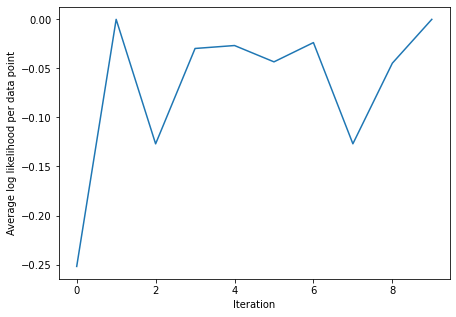

In [33]:
fig,ax = plt.subplots(figsize = (7,5))
ax.plot(range(0,10), avg_log_likelihood)
ax.set_ylabel('Average log likelihood per data point')
ax.set_xlabel('Iteration')
plt.show()

## logistic_regression_SG: batch_size=len(data) (standard gradient asent)

In [34]:
coefficients_batch, avg_log_likelihood_standard = logistic_regression_SG(feature_matrix_train, sentiment_train, initial_coefficients=np.zeros(194),
                                        step_size=5e-1, batch_size=len(feature_matrix_train), max_iter=200)

Iteration   0: Average log likelihood (of data points  [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points  [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points  [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points  [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points  [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points  [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points  [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points  [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points  [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points  [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points  [00000:47780]) = -0.61645691
Iteration  11: Average log likelihood (of data points  [00000:47780]) = -0.6

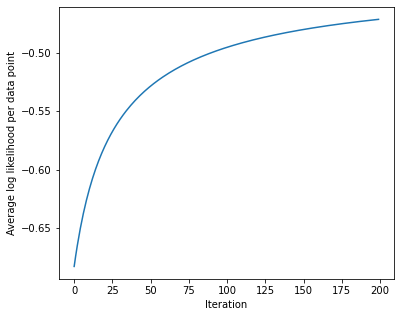

In [38]:
fig,ax = plt.subplots(figsize = (6,5))
ax.plot(range(0,200), avg_log_likelihood_standard)
ax.set_ylabel('Average log likelihood per data point')
ax.set_xlabel('Iteration')
plt.show()

### Make plots: demo

In [39]:
step_size = 1e-1
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_demo, log_likelihood_demo = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration   11: Average log likelihood (of data points  [01100:01

In [40]:
def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')

    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})

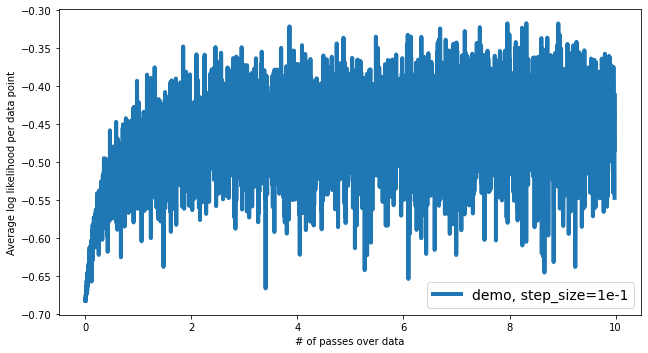

In [41]:
make_plot(log_likelihood_demo, len_data=len(feature_matrix_train), batch_size=100,
          label='demo, step_size=1e-1')


#### Smoothing the curve

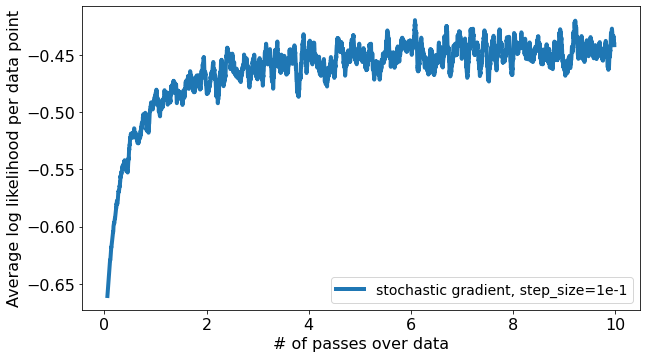

In [42]:
make_plot(log_likelihood_demo, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic gradient, step_size=1e-1')

## Compare batch gradient ascent and  standard gradient ascent

In [43]:
'''
batch gradient ascent: step_size = 0.1, batch_size=100, pass=200
standard gradient ascent: step_size = 0.5, batch_size=len(feature_matrix_train), max_iter=200
'''
step_size = 1e-1
batch_size = 100
num_passes = 200
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_batch, log_likelihood_batch = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration     0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration     1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration     2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration     3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration     4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration     5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration     6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration     7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration     8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration     9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration    10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration    11: Average log likelihood (of data point

In [44]:
coefficients_standard, log_likelihood_standard = logistic_regression_SG(feature_matrix_train, sentiment_train, 
                                        initial_coefficients=np.zeros(194),
                                        step_size=5e-1, batch_size=len(feature_matrix_train), max_iter=200)

Iteration   0: Average log likelihood (of data points  [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points  [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points  [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points  [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points  [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points  [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points  [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points  [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points  [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points  [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points  [00000:47780]) = -0.61645691
Iteration  11: Average log likelihood (of data points  [00000:47780]) = -0.6

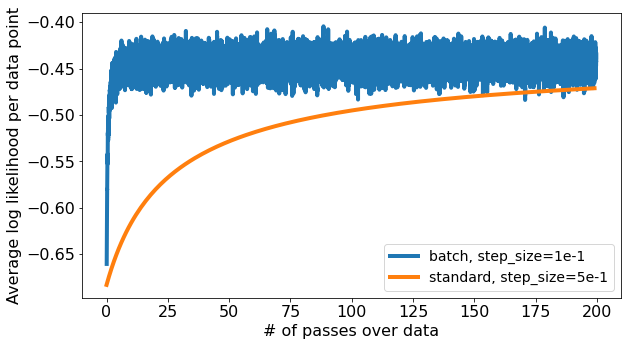

In [45]:
make_plot(log_likelihood_batch, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='batch, step_size=1e-1')
make_plot(log_likelihood_standard, len_data=len(feature_matrix_train), batch_size=len(feature_matrix_train),
          smoothing_window=1, label='standard, step_size=5e-1')

### Explore the effect of step size on batch gradient ascent

In [46]:
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd = {}
log_likelihood_sgd = {}

for step_size in np.logspace(-4, -2, num=3):
    coefficients_sgd[step_size], log_likelihood_sgd[step_size] = logistic_regression_SG(feature_matrix_train, sentiment_train,\
                                       initial_coefficients=np.zeros(194),\
                                       step_size=step_size, batch_size=batch_size, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.69313622
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.69313170
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.69313585
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.69312487
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.69313157
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.69313113
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.69311121
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.69312692
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.69312115
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.69312811
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.69311286
Iteration   11: Average log likelihood (of data points  [01100:01

In [47]:
print(np.logspace(-4, -2, num=2))

[0.0001 0.01  ]


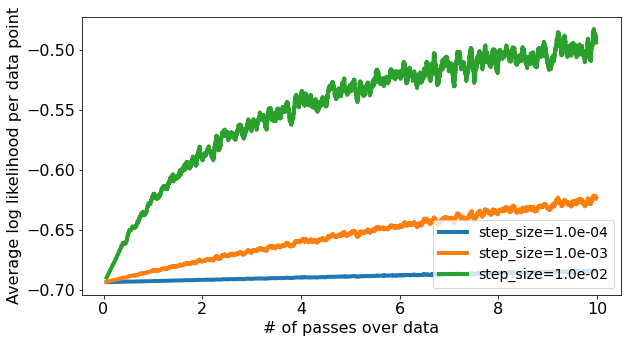

In [48]:
for step_size in np.logspace(-4, -2, num=3):
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)